# REINFORCE Method

---

In this notebook, we will train OpenAI Gym's LunarLander environment using REINFORCE algorithm.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import copy
import gym
from collections import deque, namedtuple
from torch.distributions import Categorical
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [2]:
env = gym.make('LunarLander-v2')

/home/sans/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
action_size = env.action_space.n
action_size

4

In [4]:
state_low = env.observation_space.low
state_high = env.observation_space.high
state_low, state_high

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf], dtype=float32))

In [5]:
state_size = len(state_low)
state_size

8

In [6]:
sample_state = env.observation_space.sample()
sample_state

array([-1.499723  , -0.5449795 ,  0.7257358 , -2.2710986 ,  1.1904254 ,
        0.7725752 , -0.8288671 , -0.12636793], dtype=float32)

### Initialize the model

I have created a simple neural network. Note that I have used softmax activation in the
final layer to get the probablities of all the actions. 
Also, I calculate the categorical distribution of the probablities and return the log the 
probablity of the action.

In [67]:
class Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Model, self).__init__()
        self.seed = torch.manual_seed(0)
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.fc1 = nn.Linear(state_size, 16)
#         self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, action_size)
        
    def forward(self, x):
        x = torch.from_numpy(x).float().unsqueeze(0)
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
        action_prob = F.softmax(self.fc3(x), dim=1)
        
        m = Categorical(action_prob)
        action = m.sample()
        
        return action.item(), m.log_prob(action)

In [68]:
model = Model(state_size, action_size)

In [69]:
# state = torch.from_numpy(sample_state).float().unsqueeze(0)
a, l = model(sample_state)

In [70]:
a, l

(1, tensor([-1.1177], grad_fn=<SqueezeBackward1>))

### Train the model

I tried multiple changes to make REINFORCE work LunarLander. I tried complicating the neural
network to 2 hidden layers with 256 & 512 nodes, but the loss could not come below -130. 

**If you have certain suggestion on this, to solve the env using REINFORCE. 
Fork the repo and make a PR for it.**

In [71]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
print_every = 100

def reinforce():
    score_deque = deque(maxlen=100)
    scores = []
    n_episodes = 5000
    gamma = 1.0
    
    for i_episode in range(n_episodes):
        state = env.reset()
        done = False
        all_log_probs = []
        all_rewards = []
        while not done:
            action, log_prob = model(state)
            all_log_probs.append(log_prob)
            new_state, reward, done, _ = env.step(action)
            state = new_state
            all_rewards.append(reward)
            if done:
                break
                
        score_deque.append(sum(all_rewards))
        scores.append(sum(all_rewards))
        
        discounts = [gamma**i for i in range(len(all_rewards))]
        total_reward = sum([a*b for a,b in zip(discounts, all_rewards)])
        policy_loss = []
        
        for log_prob in all_log_probs:
            policy_loss.append(-log_prob*total_reward)
        
#         for index, (log_prob, reward) in enumerate(zip(all_log_probs, all_rewards)):
#             policy_loss.append(-log_prob*reward*discounts[index])
                
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_deque)))
            
        if np.mean(score_deque) >= 200.0:
            torch.save(model.state_dict(), 'checkpoint.pth')
            break
        
    return scores

In [72]:
scores = reinforce()   ## when trained with hiddne layers of 256 & 512 nodes

Episode 0	Average Score: -403.28
Episode 100	Average Score: -181.64
Episode 200	Average Score: -166.46
Episode 300	Average Score: -131.89
Episode 400	Average Score: -142.89
Episode 500	Average Score: -160.83
Episode 600	Average Score: -121.32
Episode 700	Average Score: -119.62
Episode 800	Average Score: -168.74
Episode 900	Average Score: -562.41
Episode 1000	Average Score: -373.35
Episode 1100	Average Score: -196.66
Episode 1200	Average Score: -186.59
Episode 1300	Average Score: -159.39
Episode 1400	Average Score: -140.96
Episode 1500	Average Score: -157.79
Episode 1600	Average Score: -150.93
Episode 1700	Average Score: -140.56
Episode 1800	Average Score: -136.26
Episode 1900	Average Score: -143.72
Episode 2000	Average Score: -154.67
Episode 2100	Average Score: -137.92
Episode 2200	Average Score: -141.35
Episode 2300	Average Score: -130.13
Episode 2400	Average Score: -136.01
Episode 2500	Average Score: -131.83
Episode 2600	Average Score: -139.78
Episode 2700	Average Score: -136.22
Epis

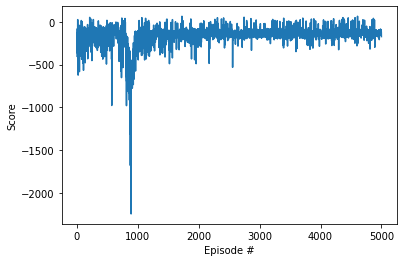

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()